In [2]:
import nengo
import numpy as np

import scipy
from scipy.stats import special_ortho_group

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

# Parameters

In [25]:

# state space adaptive controller, random encoders
params_statespace = {
    'radius'        : 1.,
    'use_ssp'       : False,
    'gain'          : 1000.,
    'rho_specified' : 0.421
}

params_selected = {
    'limits' : [[-np.pi,np.pi],[-np.pi,np.pi]],
    'x_mean' : [0,0], #X mean, X dot mean
    'gain'   : 100,
    'rho_specified' : 0.421
}

# ssp space adaptive controller - random encoders
# nni or01dmag
params_ssp_rnd = {
    'use_ssp'       : True,
    'ssp_dim'       : 512,
    'encoders_type' : 'random',
    'psd_sampling'  : 'gaussian',
    'ssp_ls1'       : 0.82,
    'ssp_ls2'       : 5.31,
    'rho_specified' : 0.421,
    'gain'          : 100.,
}

# ssp space adaptive controller - place cells
# nni 4187nymr
params_ssp_plc = {
    'use_ssp'       : True,
    'ssp_type'      : 'random',
    'ssp_dim'       : 512, #hyperopt found 128
    'encoders_type' : 'place-cells',
    'psd_sampling'  : 'gaussian',
    'ssp_ls1'       : 0.82,
    'ssp_ls2'       : 5.31,
    'rho_specified' : 0.421,
    'gain'          : 100.,
}


# ssp space adaptive controller - grid cells
params_ssp_grid = {
    'use_ssp'       : True,
    'ssp_type'      : 'hexssp',
    'encoders_type' : 'grid-cells',
    'ssp_dim'       : 512,
    'ssp_ls1'       : 0.1,
    'ssp_ls2'       : 0.5,
    'rho_specified' : 0.421,
    'gain'          : 100.,
}

params_dict = {
    'statespace' : params_statespace,
    'selected'   : params_selected,
    'ssp_rnd'    : params_ssp_rnd,
    'ssp_plc'    : params_ssp_plc,
    'ssp_grid'   : params_ssp_grid
}

# Functions


In [4]:
#For selected basis
#Chooses encoders on D+1 hypersphere
def projection(X): 
    n = len(X) + 1
    X_proj = np.zeros(n)
    X_proj[-1] =  np.prod(np.sin(X))
    for i in range(n-2, -1, -1):
        X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
    return X_proj

def selected_encoders(dim,num_neurons):
    X = np.zeros((dim,num_neurons))
    for d in range(dim):
        X[d,:] = np.linspace(-np.pi,np.pi,num_neurons)
    X_proj = np.zeros((dim+1,num_neurons))
    for n in range(num_neurons):
        X_proj[:,n] = projection(X[:,n])
    return np.transpose(X_proj)

class selected_basis:
    def __init__(self):
        pass
    def encode(self,X_batch):
        
        batch_size,dim = X_batch.shape
        n = dim +1
        
        X_out = np.zeros((batch_size,n))
        for i in range(batch_size):
            X_out[i,:] = projection(X_batch[i,:])
        
        return X_out    

def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)

def generate_hex_phase_matrix(d,n,rng=np.random.RandomState(), max_scale=1):
    # Get the n+1 vertices of the regular n-simplex
    # (for n=2 this is an equilateral triangle)
    # (for n=3 this is a tetrahedron)
    simplex_vertices = np.hstack([np.sqrt(1+ 1/n)*np.identity(n) - (n**(-3/2))*(np.sqrt(n+1) + 1),
                         (n**(-1/2))*np.ones((n,1))]).T
    
    # We want to take this set of vectors and compute different scales and rotations of the set to fill A
    # This is computing the # of scales/rotations can be fit to make an with *close* to d rows
    # This constrains what values d can take on
    if d % 2 == 0:
        n_transforms = ((d-2)//2)//(n+1)
        d = 2*n_transforms*(n+1) + 2
    else:
        n_transforms = ((d-1)//2)//(n+1)
        d = 2*n_transforms*(n+1) + 1

    A = np.zeros((d, n))
    # Real terms (DC & Nyq)
    A[0] = 0
    if d % 2 == 0:
        A[d // 2] = 0
        
    # Random samples of scales
    scales = max_scale*rng.rand(n_transforms)
    
    # Random samples of rotation matrices
    rotation_mats = special_ortho_group(n, seed=rng).rvs(size=n_transforms).reshape(n_transforms,n,n)
    
    # Apply transforms & fill half of A
    A[1:(d + 1) // 2,:] = np.vstack([scales[i] * simplex_vertices @ rotation_mats[i].T for i in range(n_transforms)]) 
    
    # Negate & flip for second half for symmetry
    A[-1:d // 2:-1] = -A[1:(d + 1) // 2,:]
    
    return A

def sample_grid_encoders(n_neurons, A, radius=1):
    d = A.shape[0]
    n = A.shape[1]
    
    if d % 2 == 0:
        N = ((d-2)//2)//(n+1)
    else:
        N = ((d-1)//2)//(n+1)

    sample_pts = radius*np.random.rand(n_neurons, n)    
    sorts =  np.random.randint(0, N, size = n_neurons)      
        
    encoders = np.zeros((n_neurons,d))
    for i in range(n_neurons):
        res = np.zeros(d, dtype=np.complex64)
        res[(1 + sorts[i]*(n+1)):(n + 2 + sorts[i]*(n+1)) ] = np.exp( 1.j * A[(1 + sorts[i]*(n+1)):(n + 2 + sorts[i]*(n+1)) ] @ sample_pts[i,:])
        res[-(n + 1 + sorts[i]*(n+1)):-(sorts[i]*(n+1)+ (sorts[i]==0))] = np.exp( 1.j * A[-(n + 1 + sorts[i]*(n+1)):-(sorts[i]*(n+1) + (sorts[i]==0))] @ sample_pts[i,:])
        res[0] = 1
        if d%2==0:
            res[d//2] = 1
        encoders[i,:] = np.fft.ifft(res).real
    return encoders

def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T


# Simulation

statespace


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

actual expected sparsity over the domain:  0.499994
selected


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

actual expected sparsity over the domain:  0.498516
ssp_rnd


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

actual expected sparsity over the domain:  0.494202
ssp_plc


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

actual expected sparsity over the domain:  0.522835
ssp_grid
512


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

actual expected sparsity over the domain:  0.763807


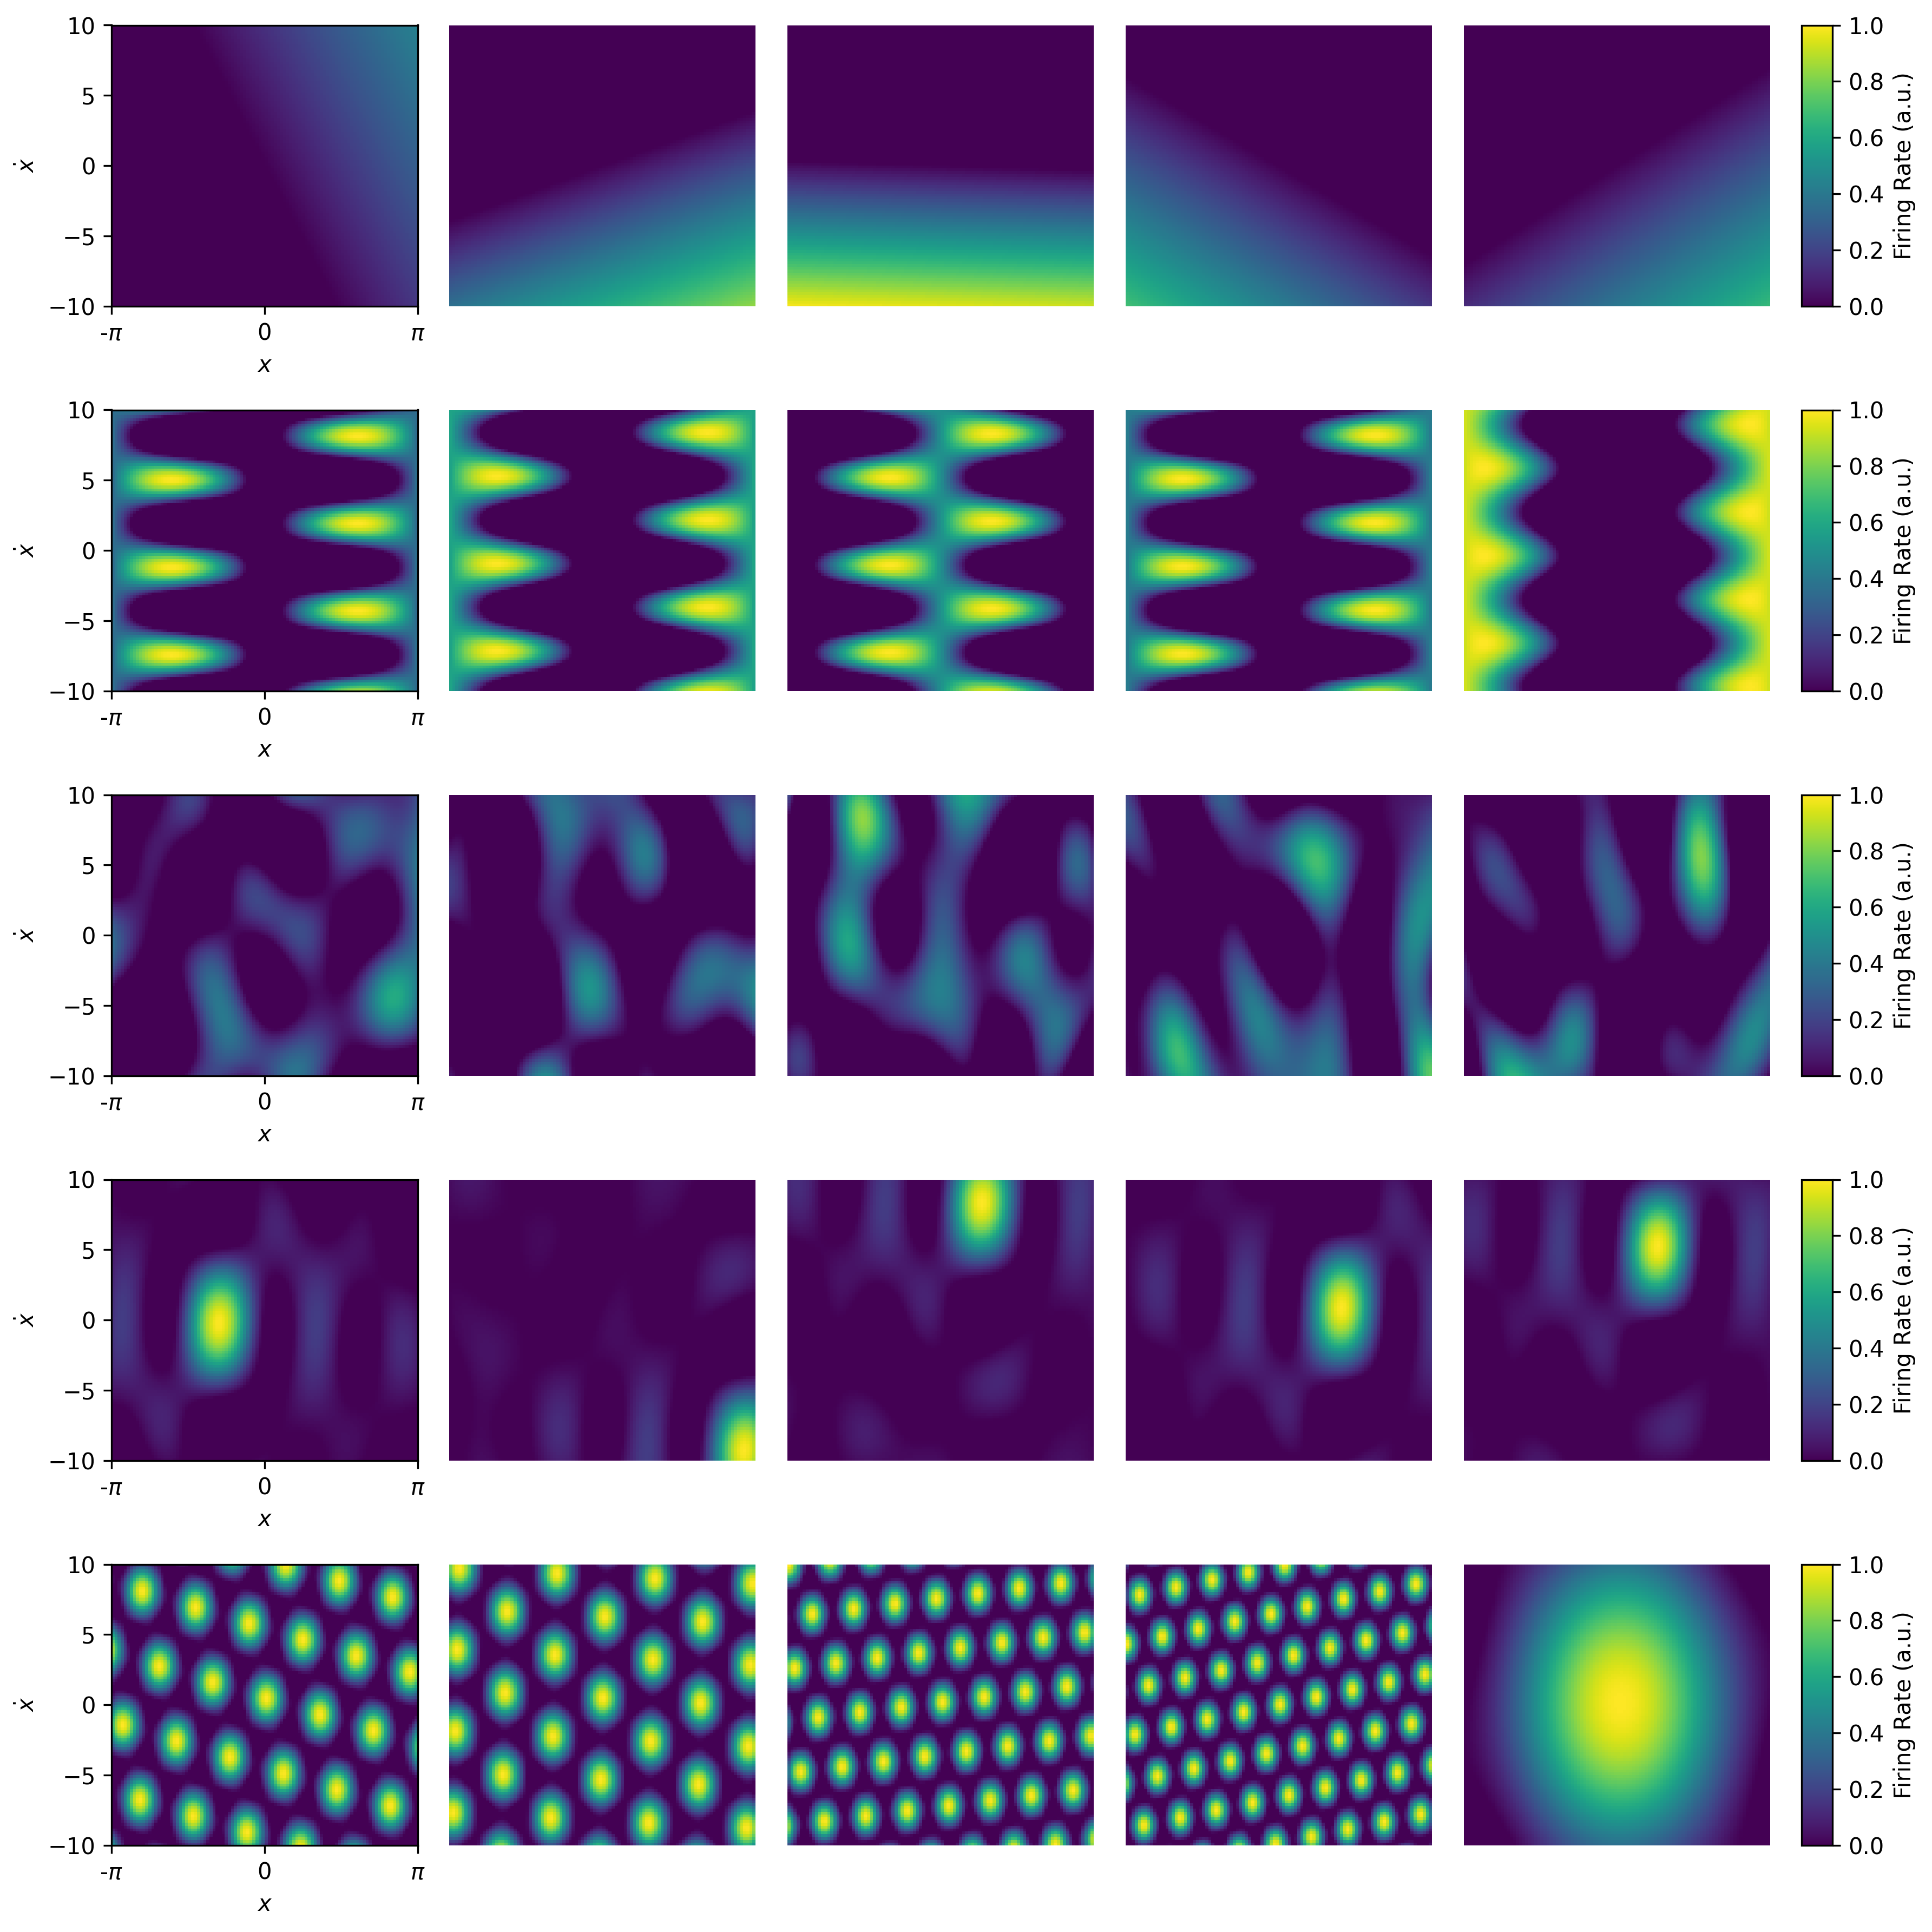

In [26]:
neuron_type = nengo.RectifiedLinear()
n_neurons = 100
domain_ranges_ = np.array([[-np.pi,np.pi],[-10,10]])
domain_dim = 2        

fig,axes = plt.subplots(5,6,figsize=(12.,12.),gridspec_kw = {'width_ratios':[10,10,10,10,10,1]})
for (basis,params),a in zip(params_dict.items(),range(5)):
    print(basis)
    
    if basis == 'statespace':
        dimensions = domain_dim
        radius = params['radius']
        xi = -sparsity_to_x_intercept(d=dimensions,p=params['rho_specified'])
        encoder = None
        neuron_encoders = nengo.Default
        gain = params['gain']
        
    elif basis == 'selected':
        dimensions = domain_dim + 1
        encoder = selected_basis()
        xi = -sparsity_to_x_intercept(d=dimensions,p=params['rho_specified'])
        neuron_encoders = selected_encoders(2, n_neurons)
        gain = params['gain']
    
    if (basis == 'ssp_rnd') or (basis == 'ssp_plc'):
        dimensions = params['ssp_dim']
        encoder = RandomSSPSpace( domain_dim = domain_dim, 
                                     ssp_dim = dimensions, 
                                     length_scale = np.array([params['ssp_ls1'],params['ssp_ls2']]),
                                     psd_sampling = 'uniform'
                                )
    elif (basis == 'ssp_grid'):
        A_hex = generate_hex_phase_matrix( dimensions, domain_dim )
        encoder = SSPEncoder( phase_matrix = A_hex, 
                               length_scale = np.array([params['ssp_ls1'],params['ssp_ls2']])
                          )
        print(encoder.ssp_dim)
        
    xi = -sparsity_to_x_intercept(d=dimensions,p=params['rho_specified'])
    gain = params['gain']

    if basis == 'ssp_rnd':
        neuron_encoders = nengo.dists.UniformHypersphere(surface=True).sample(n_neurons, dimensions)

    elif basis == 'ssp_plc':
        neuron_encoder_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(n_neurons,2))
        neuron_encoders = encoder.encode(neuron_encoder_xs)

    elif basis == 'ssp_grid':
        neuron_encoders = sample_grid_encoders(n_neurons,A_hex)
        
    with nengo.Network() as model:
            
        ens = nengo.Ensemble(     n_neurons = n_neurons, 
                                  dimensions = dimensions,
                                  gain = gain*np.ones(n_neurons),
                                  bias = np.zeros(n_neurons) + xi,
                                  neuron_type = neuron_type,
                                  encoders = neuron_encoders,
                                  normalize_encoders = False,
                                 )

    sim = nengo.Simulator(model)
    n_eval_points = 100
    meshes = np.meshgrid(*[np.linspace(b[0], b[1], n_eval_points) 
                            for b in domain_ranges_])
    eval_xs = np.vstack([m.flatten() for m in meshes]).T
    
    inputs = np.zeros( (eval_xs.shape[0],dimensions) )
    if encoder is not None:
        inputs = encoder.encode(eval_xs)

    else:
        inputs = eval_xs
    _,A = nengo.utils.ensemble.tuning_curves( ens = ens, sim = sim, inputs = inputs )

    rho_actual = ( A > 0 ).mean()
    print('actual expected sparsity over the domain: ', rho_actual)
    
    A /= A.max()
    axs = axes[a,:-1]
    cax = axes[a,-1]
    
#    np.random.seed(0)
#     np.random.seed(7)
    np.random.seed(1)
    neurons_to_show = np.random.choice(range(n_neurons),5,replace=False)
    for n,ax in zip (neurons_to_show,axs.ravel()):
        im = ax.imshow(A[:,n].reshape(n_eval_points,n_eval_points),
                      origin = 'lower',
                      extent = domain_ranges_.ravel(),
                      aspect = 'auto',
                      vmin = 0., vmax = 1.
                 )
        if ax == axs[0]:
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$\dot x$')
        else:
            ax.axis('off')
            
        xticks = [-np.pi,0,np.pi]
        xticklabels = [r'-$\pi$',0,r'$\pi$']
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        yticks = [-10,-5,0,5,10]
        ax.set_yticks(yticks)
    fig.colorbar(im,cax=cax,label='Firing Rate (a.u.)')
fig.tight_layout()
plt.savefig('basis_functions_receptive_fields.pdf',format='pdf')
plt.show()